## GRUPO 2: ##
Marta Pizarro       202027959

Diego Quevedo       200914623

Alfredo Hincapié    199817792

Guillermo Andrade   202027949

Elber Pardo         200017815

# Exercise 8

The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository. The project must be carried out in the groups assigned in class. Use clear and rigorous procedures. Due date: July 18, 2021, 11:59 pm, through Bloque Neón + (Upload repository link)

## Car Price Prediction

Predict if the price of a car is low or high

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('../datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [4]:
data.shape

(13150, 10)

In [5]:
np.count_nonzero(data['HighPrice'])

7621

In [6]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the decision trees notebook.

Evaluate the accuracy on the testing set

In [8]:
#Parámetros para el árbol
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [9]:
# Para el feature 1 se van a calcular los posibles puntos de corte
j = 1
print(X.columns[j])

Mileage


In [10]:
# Se divide la variable en los puntos de corte, de acuerdo con el número definido en num_pct
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [11]:
#Se toman los valores únicos resultado de la deivisión
splits = np.unique(splits)
splits

array([6.000000e+00, 1.603480e+04, 2.324080e+04, 2.987540e+04,
       3.565100e+04, 4.160950e+04, 4.849280e+04, 6.199830e+04,
       8.097420e+04, 1.061537e+05])

#### Gini

Definimos la función para determinar la impuridad de Gini para cada nodo

In [12]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [13]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [14]:
gini_impurity(X_train.iloc[:, j], y_train, splits[5])

0.18743041714283493

Se prueban todas las particiones para todas variables

In [15]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [16]:
j, split, gain = best_split(X_train, y_train, 10)
j, split, gain

(1, 52187.63636363637, 0.23872134898880762)

Donde la mejor variable o feature es la 1 "Mileage" (Kilometraje) y se debe partir usando el valor de 52187.63, obteniendo una ganancia de Gini de 0.238

Comprobamos la proporción de los datos que se están logrando dividir

In [17]:
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [18]:
y_train.mean(), y_l.mean(), y_r.mean()

(0.5780930760499432, 0.839279343560471, 0.12109862671660425)

En el set total de datos el 57.8% de los autos tienen precios altos, con la división realizada, por la izquierda el 83.9% de los autos tienen precio alto, y por la izquierda el 12.1% de los autos tienen precio alto, por lo cual esta división ya está logrando una buena clasificación

Ahora se aplica una función recursiva con el fin de generar el árbol con las particiones que obtengan una mayor ganancia de Gini en cada iteración

In [19]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [20]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=5, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': -1,
      'n_samples': 23,
      'gain': 0.03456656764785304},
     'sr': {'y_pred': 0,
      'y_prob': 0.03125,
      'level': 5,
      'split': -1,
      'n_samples': 62,
      'gain': 0

#### Se realiza la predicción

In [21]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted 

In [22]:
y_calc= tree_predict(X_test, tree)
y_calc

array([1., 1., 1., ..., 1., 1., 0.])

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_calc)

0.8730414746543779

# Exercise 8.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in bagging notebook.

Evaluate the accuracy on the testing set

In [24]:
# Se fija la semilla para replicabilidad
np.random.seed(543)

n_samples = X_train.shape[0]
n_B = 10

# Se crean las 10 muestras de bootstrap, seleccionando diferentes filas del dataframe
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([ 561, 8671, 7581, ..., 5941, 4622,  753]),
 array([3164, 3318, 8243, ..., 6224, 4327, 3213]),
 array([7648, 2326, 4731, ...,  183, 8679, 2312]),
 array([3891, 5780, 5531, ..., 1309, 3123, 8690]),
 array([3256, 3893, 6526, ..., 5683,  211, 2583]),
 array([2574, 8502, 5537, ..., 7856,  588, 4528]),
 array([1186, 1222, 3326, ..., 4558, 6660, 1120]),
 array([3121, 3601, 1772, ..., 4926, 2570, 5889]),
 array([3758, 8537, 8448, ..., 3375, 2236, 7761]),
 array([2200,  319, 5979, ..., 5574,  284, 7476])]

Se crea un árbol con cada muestra de datos creada del set de train

In [25]:
from sklearn.tree import DecisionTreeRegressor

# Se define la creación del árbol
treereg = DecisionTreeRegressor(max_depth=None, random_state=543)

# Se almacena la predicción de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [32]:
# Se crea cada árbol con cada muestra de bootstrap y se realizan las predicciones con el set de test
for i, sample in enumerate(samples):
    X_train1 = X_train.iloc[sample]
    y_train1 = y_train.iloc[sample]
    treereg.fit(X_train1, y_train1)
    y_pred[i] = treereg.predict(X_test).astype('int')

In [33]:
y_pred

,0,1,2,3,4,5,6,7,8,9
332784,0,0,1,1,0,0,0,1,0,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
244795,1,1,1,1,1,1,1,1,1,1
366403,0,0,0,0,0,0,0,0,0,0
269482,1,1,1,1,1,0,1,1,1,1
5010,1,1,1,1,1,1,1,1,1,1


In [34]:
#Resultado de cada árbol
for i in range(n_B):
    print(i, accuracy_score(y_test,y_pred[i]))

0 0.8414746543778802
1 0.8311059907834102
2 0.832258064516129
3 0.8320276497695852
4 0.836405529953917
5 0.8341013824884793
6 0.8281105990783411
7 0.832258064516129
8 0.8283410138248848
9 0.8317972350230415


Resultados del ensamble

In [41]:
pred_ensamble=np.round(y_pred.mean(axis=1)).astype('int')
pred_ensamble

332784    0
146436    1
130476    1
85618     1
75474     0
         ..
244795    1
366403    0
269482    1
5010      1
310628    0
Length: 4340, dtype: int32

In [42]:
accuracy_score(y_test,pred_ensamble)

0.8465437788018433

Se observa como la precisión mejora en comparación con los modelos individuales donde el mejor resultado era 0.8414, obteniendo con el ensamble una precisión de 0.8465

# Exercise 8.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

Se toma la función donde se realiza la partición de cada variable, donde se va a modificar para que no tenga en cuenta todas sino las que se definan como max_features y se ajustan las funciones para incorporar el cambio

In [172]:
def best_split(X, y, max_features = 1, num_pct=10):
    
    features = range(0,max_features)
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [173]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, max_features = 1, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, max_features, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [175]:
# Lista de número max_features a probar
features_range = range(0, 9)

# lista para almacenar la precisión de los árboles al utilizar la muestra de test
accuracy_scores = []

for estimator in features_range:
    tree2 = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_features=estimator, max_depth=5, num_pct=10)
    y_calc2= tree_predict(X_test, tree2)
    accuracy_scores.append(accuracy_score(y_test,y_calc2))

Text(0, 0.5, 'Accuracy')

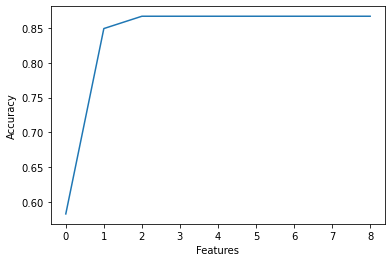

In [176]:
plt.plot(features_range, accuracy_scores)
plt.xlabel('Features')
plt.ylabel('Accuracy')

Donde luego de usar más de 2 variables, la precisión del modelo en test tiende a estabilizarse, lo cual se podría explicar dado que en este modelo no se está haciendo un ensamble y adicionalmente deben existir 2 variables más representativas o con mayor peso a la hora de realizar la clasificación

# Exercise 8.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [47]:
# Se fija la semilla para replicabilidad
np.random.seed(543)

n_samples2 = X_train.shape[0]
n_features = X_train.shape[1]
n_B2 = 10

# Se crean las 10 muestras de bootstrap, seleccionando diferentes filas del dataframe
samples2 = [np.random.choice(a=n_samples2, size=n_samples2, replace=True) for _ in range(1, n_B2 +1 )]
samples2

[array([ 561, 8671, 7581, ..., 5941, 4622,  753]),
 array([3164, 3318, 8243, ..., 6224, 4327, 3213]),
 array([7648, 2326, 4731, ...,  183, 8679, 2312]),
 array([3891, 5780, 5531, ..., 1309, 3123, 8690]),
 array([3256, 3893, 6526, ..., 5683,  211, 2583]),
 array([2574, 8502, 5537, ..., 7856,  588, 4528]),
 array([1186, 1222, 3326, ..., 4558, 6660, 1120]),
 array([3121, 3601, 1772, ..., 4926, 2570, 5889]),
 array([3758, 8537, 8448, ..., 3375, 2236, 7761]),
 array([2200,  319, 5979, ..., 5574,  284, 7476])]

Se crea un árbol con cada muestra de datos creada del set de train

In [68]:
from sklearn.tree import DecisionTreeRegressor
#Se crea la variable que va a tomar el valor de log(n_features) para el parámetro max_features
b= np.round(np.log(n_features)).astype('int')
# Se define la creación del árbol 
treereg2 = DecisionTreeRegressor(max_depth=None, max_features =b , random_state=543)

# Se almacena la predicción de cada árbol
y_pred2 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B2))])

In [69]:
# Se crea cada árbol con cada muestra de bootstrap y se realizan las predicciones con el set de test
for i, sample in enumerate(samples2):
    X_train2 = X_train.iloc[sample]
    y_train2 = y_train.iloc[sample]
    treereg2.fit(X_train2, y_train2)
    y_pred2[i] = treereg2.predict(X_test).astype('int')

In [70]:
y_pred2

,0,1,2,3,4,5,6,7,8,9
332784,0,0,1,1,0,0,0,1,0,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
244795,1,1,1,1,1,1,1,1,1,1
366403,0,0,0,0,0,0,0,0,0,0
269482,1,1,1,1,1,1,0,1,1,1
5010,1,1,1,1,1,1,1,1,1,1


In [79]:
#Resultado de cada árbol
for i in range(n_B2):
    print(i, accuracy_score(y_test,y_pred2[i]))

0 0.841705069124424
1 0.8357142857142857
2 0.8359447004608295
3 0.8347926267281106
4 0.8352534562211982
5 0.8354838709677419
6 0.8313364055299539
7 0.8366359447004609
8 0.8297235023041475
9 0.8357142857142857


Resultados del ensamble

In [77]:
pred_ensamble2=np.round(y_pred2.mean(axis=1)).astype('int')
pred_ensamble2

332784    0
146436    1
130476    1
85618     1
75474     0
         ..
244795    1
366403    0
269482    1
5010      1
310628    0
Length: 4340, dtype: int32

In [78]:
accuracy_score(y_test,pred_ensamble2)

0.8389400921658986

Al tomar el valor de las variables máximas a tomar para hacer la muestra de cada bootstraping como log(n_features), es decir log(9) ≈ 2, se evidencia que el ensamble no es tan efectivo como cuando se tomo el total de las variables (9), ya que para este caso la precisión no alcanza a mejorar la mejor precisión del modelo individual (0.8417)

# Exercise 8.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [83]:
modelclf=clf.fit(X_train,y_train)

In [86]:
predclf=modelclf.predict(X_test).astype('int')
predclf

array([0, 1, 1, ..., 1, 1, 0])

In [87]:
accuracy_score(y_test,predclf)

0.8377880184331797

# Exercise 8.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings; 
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')
clf2 = RandomForestClassifier()
clf2

RandomForestClassifier()

Calibrando el número de árboles

In [101]:
# Lista de número de árboles a crear para el ensamble
estimator_range = range(0, 2000, 100)

# lista para almacenar la precisión promedio para cada valor del número de árboles
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor del número de árboles
for estimator in estimator_range:
    clf2 = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf2, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

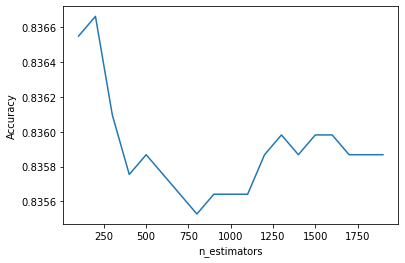

In [102]:
#Se grafican los resultados
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

Se evidencia que la precisión del modelo no varia mucho con el número de árboles, y tiene su mayor desempeño aproximadamente en 100, por lo cual se va a tomar dicho valor

Calibrando max_features

In [111]:
# lista de valores para max_feature
feature_cols=X_train.shape[1]
feature_range = range(1, feature_cols+1)

# lista para almacenar la precisión promedio para cada valor de número variables
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor del número de variables,
# y se establece el número de árboles en 100 de acuerdo con el punto anterior
for feature in feature_range:
    clf2 = RandomForestClassifier(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf2, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

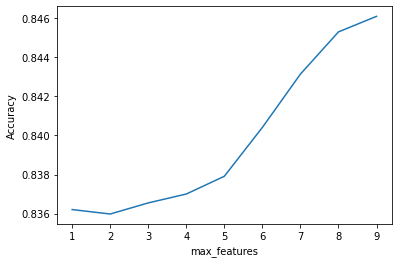

In [112]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

Encontrando la mejor precisión usando todas las variables

Calibrando max_depth

In [148]:
# lista de valores para la profundidad del árbol
depth_range = range(1, 20)

# lista para almacenar la precisión promedio para cada valor de número variables
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor del número de variables,
# y se establece el número de árboles en 100 y max_features en 9 de acuerdo con el punto anterior
for estimator in depth_range:
    clf2 = RandomForestClassifier(n_estimators=100, max_features=9, max_depth= estimator,random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf2, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

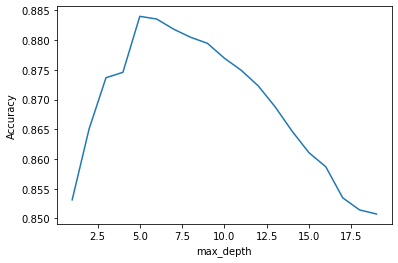

In [149]:
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Encontrando la mejor precisión usando una profundidad de 5

In [150]:
clf2 = RandomForestClassifier(n_estimators=100, max_features=9, max_depth= 5,random_state=1, n_jobs=-1)
clf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=9, n_jobs=-1, random_state=1)

In [151]:
predclf2=clf2.predict(X_test).astype('int')
predclf2

array([1, 1, 1, ..., 1, 1, 0])

In [152]:
accuracy_score(y_test,predclf2)

0.8797235023041474

Obteniendo una mayor precisión que con el modelo sin calibrar

# Exercise 8.7 

Using xgboost train a XGBClassifier 

Evaluate the accuracy on the testing set

In [135]:
from xgboost import XGBClassifier

clf3 = XGBClassifier(eval_metric='mlogloss')
clf3

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [136]:
clf3.fit(X_train, y_train)
predclf3 = clf3.predict(X_test)

In [137]:
accuracy_score(y_test,predclf3)

0.8790322580645161

# Exercise 8.8

Using xgboost train a XGBClassifier 

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

In [126]:
clf4 = XGBClassifier()
clf4

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

#### Learning rate
La tasa de aprendizaje reduce la contribución de cada árbol para el aprendizaje del modelo ensamblado (entre 0 y 1), para evitar el sobre ajuste.

In [138]:
# Rango para los cuales se va a probar la tasa de aprendizaje
estimator_range = np.arange(0, 1, 0.05)

# lista para almacenar la precisión promedio para cada valor de la tasa de aprendizaje
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor de la tasa de aprensizaje
for estimator in estimator_range:
    clf4 = XGBClassifier(learning_rate=estimator,eval_metric='mlogloss')
    accuracy_scores.append(cross_val_score(clf4, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

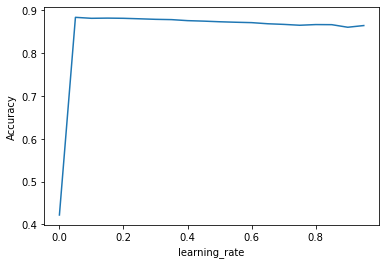

In [139]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

Donde la mejor precisión se obtiene aproximadamente con un learnin_rate de 0.05

#### gamma
El parámetro Gamma especifica la reducción de pérdida mínima necesaria para realizar una división en un nodo. Hace que el algoritmo sea conservador. Entre (0, ∞)

In [140]:
# Rango para los cuales se va a probar el valor gamma
gamma_range = range(0, 20, 2)

# lista para almacenar la precisión promedio para cada valor de gamma
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor de gamma,se usa el valor de 0.05 para la tasa de 
# aprendizaje de acuerdo con el punto anterior
for estimator in gamma_range:
    clf4 = XGBClassifier(learning_rate=0.5, gamma= estimator, eval_metric='mlogloss')
    accuracy_scores.append(cross_val_score(clf4, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

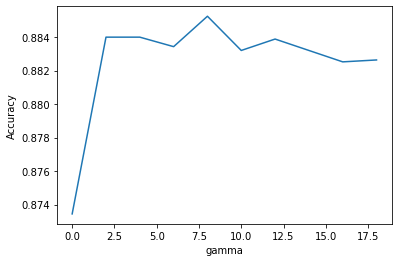

In [141]:
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

Donde la mejor precisión se obtiene aproximadamente con un gamma de 8

#### colsample_bytree
El parámetro colsample_bytree especifica la cantidad de columnas a usar para construir cada submuestra con la que se construira cada árbol. Entre (0, 1)

In [143]:
# Rango para los cuales se va a probar el valor colsample_bytree
colsampletree_range = np.arange(0, 1, 0.1)

# lista para almacenar la precisión promedio para cada valor de colsample_bytree
accuracy_scores = []

# Se usan 5 particiones para realizar cross-validation para cada valor de colsample_bytree,se usa el valor de 0.05 para la 
#tasa de aprendizaje y 8 para gamma de acuerdo con el punto anterior
for estimator in colsampletree_range:
    clf4 = XGBClassifier(learning_rate=0.5, gamma= 8, colsample_bytree=estimator, eval_metric='mlogloss')
    accuracy_scores.append(cross_val_score(clf4, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

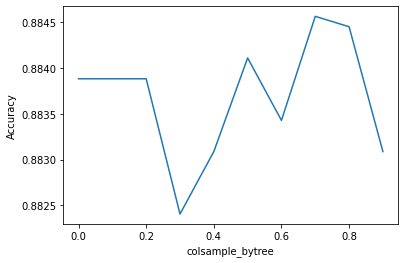

In [144]:
plt.plot(colsampletree_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('Accuracy')

Donde la mejor precisión se obtiene aproximadamente con un colsample_bytree de 0.7

In [145]:
#Se ejecuta el modelo con los mejores parámetros encontrados
clf4 = XGBClassifier(learning_rate=0.5, gamma= 8, colsample_bytree=0.7, eval_metric='mlogloss')

In [146]:
clf4.fit(X_train, y_train)
predclf4 = clf4.predict(X_test)

In [147]:
accuracy_score(y_test,predclf4)

0.881336405529954

Donde se mejora la precisión versus el modelo de XGBClassifier sin calibración (pasando de 0.879 a 0.881), siendo el mejor modelo de los probados durante todo el ejercicio